In [1]:
#!/usr/bin/python
import sys
import time
import redpitaya_scpi as scpi

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
# For bigger inline plots (size in "inches")
plt.rcParams['figure.figsize'] = [8, 6]

IP = '192.168.1.117'

# Custom Pulse(s)

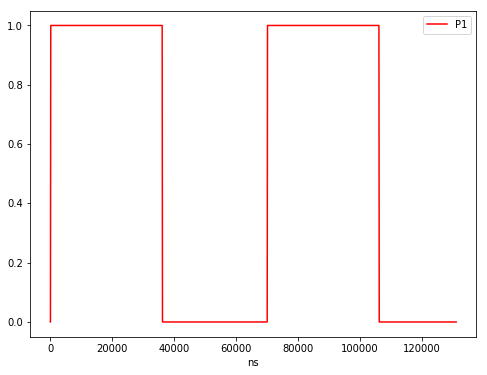

In [2]:
def sloping_pulse(start, slope_length, pulse_width, size=2**14):
    # Entries now in ns!!
    """By default the there are three samples with value zero at the start of the pulse.
    Otherwise the DC signal starts going mayhem after. This means the earliest possible 
    pulse always has a start time of 24 ns"""
    
    start = round(start/8) + 3 
    slope_length = round(slope_length/8)
    pulse_width = round(pulse_width/8)
    
    amplitude = 1
    if size is None:
        size = start + 2*slope_length + pulse_width + 3
    
    pulse = np.zeros(size)
    
    slope = np.linspace(0, amplitude, slope_length)
    total_pulse_length = start + 2*slope_length + pulse_width + 3
    
    pulse[start : start + slope_length] = slope
    pulse[start + slope_length : start + slope_length + pulse_width] = amplitude
    pulse[start + slope_length + pulse_width : pulse_width + start + 2*slope_length] = np.flip(slope, axis=0)
    
    
    return pulse
    
def shift_ns(array, ns):
    "Rounded to a whole number of samples"
    
    from scipy.ndimage import shift
    
    samples = ns / 8
    
    return shift(array, round(samples))

t = np.arange(0, 2**14)*8

test1 = sloping_pulse(start=0, slope_length=80, pulse_width=4500*8) + sloping_pulse(start=70000, slope_length=80, pulse_width=4500*8)


end = -1

plt.plot(t[:end], test1[:end], label='P1', color='r')

#plt.plot(vfilt)
plt.xlabel('ns')
plt.legend()

In [3]:
def setup_asg(output=1, waveform='sine', frequency=1000, amplitude=0, burst_mode=False, bursts=1,
              b_reps=1, b_time=None, data=None):
    
    waveforms = {'sine', 'square', 'triangle', 'sawu', 'sawd', 'pwm', 'arbitrary'}
    # Check validity of output
    if output == 1:
        source = 'SOUR1'
    elif output == 2:
        source = 'SOUR2'
    else:
        raise Exception(f'Output = {output} is not a valid input, only 1 or 2.')
    
    # Check validity of waveform
    if waveform in waveforms:
        rp.tx_txt(source + ':FUNC ' + str(waveform).upper())
        if waveform == 'arbitrary':
            rp.tx_txt(source + ':TRAC:DATA:DATA ' + ','.join(map(str, data)))
    else:
        raise Exception(f'Invalid waveform. Possible waveforms: {waveforms}.')
    
    # set frequency
    if 0 <= frequency <= 62.5e6:
        rp.tx_txt(source + ':FREQ:FIX ' + str(frequency))
    else:
        raise Exception(f'Frequency should be between 0 Hz and 62.5e6 Hz.')
    
    # set amplitude
    if -1 <= amplitude <= 1:
        rp.tx_txt(source + ':VOLT ' + str(amplitude))
    else:
        raise Exception(f'Amplitude should be between -1 V and 1 V.')
    
    # Burst mode
    if burst_mode is True:
        rp.tx_txt(source + ':BURS:STAT ON')
        # nr of bursts
        rp.tx_txt(source + ':BURS:NCYC ' + str(bursts))
        rp.tx_txt(source + ':BURS:NOR ' + str(b_reps))
        if b_time is not None and (500e6 > b_time > 1):
            rp.tx_txt(source + ':BURS:INT:PER ' + str(int(b_time)))      # us
    elif burst_mode is False:
        pass
    else:
        raise Exception(f'Burst mode is True or False.')
    
    rp.tx_txt('OUTPUT' + str(output) + ':STATE ON')

In [5]:
def setup_scope(gain1, gain2, decimation=1, trigger_level=0, trigger_delay=0, trigger_source='awg_pe'):
    
    rp.tx_txt('ACQ:RST')                # reset scope
    _decimations = {2 ** n: 2 ** n for n in range(0, 17)}   
    _max_samples = (2**14)
    
    # <decimation> = {1,8,64,1024,8192,65536} 2**0 --> 2**16
    if decimation in _decimations.values():
        rp.tx_txt('ACQ:DEC ' + str(decimation))
    else:
        raise Exception(f'Possible decimations: {_decimations.values()}')
    
    if -1e3 < trigger_level < 1e3:   
        rp.tx_txt('ACQ:TRIG:lEV ' + str(trigger_level))            # in mV
    else:
        raise Exception(f'Trigger level should be between -1e3 mV and 1e3 mV.')

    # 0 samples delay set trigger to center of the buffer
    # Signal on your graph will have trigger in the center (symmetrical)
    # Samples from left to the center are samples before trigger
    # Samples from center to the right are samples after trigger
    
    if -_max_samples/2 <= trigger_delay <= _max_samples/2:
        rp.tx_txt('ACQ:TRIG:DLY ' + str(trigger_delay))     # in samples
    else:
        raise Exception(f'Trigger delay should be between {-_max_samples} and {max_samples}.')
    
    rp.tx_txt('ACQ:START')
    time.sleep(1)
    
    if (gain1.upper() and gain2.upper()) in {'LV', 'HV'}:
        rp.tx_txt('ACQ:SOUR1:GAIN ' + gain1.upper())
        rp.tx_txt('ACQ:SOUR2:GAIN ' + gain2.upper())
    else:
        raise Exception(f'Gain can either be "LV" or "HV".')
    
    # trigger source setting MUST be after 'ACQ:START'
    # AWG = arbitrary signal generator, PE = postitive edge, NE = negative edge
    _trigger_sources = {'DISABLED', 'NOW', 'CH1_PE', 'CH1_NE', 'CH2_PE', 
                              'CH2_NE', 'EXT_PE', 'EXT_NE', 'AWG_PE', 'AWG_NE'}
    
    if trigger_source.upper() in _trigger_sources:
        rp.tx_txt('ACQ:TRIG ' + str(trigger_source).upper())
    else:
        raise Exception(f'Possible oscillscope trigger sources are: {_trigger_sources}.')
    
def acquire(channel=1, awg_trigger_source='imm'):

    if str(channel).upper() == 'BOTH':
        
        rp.tx_txt('SOUR:TRIG:IMM')
        print('both')
        
        # Should calculate actual needed time...not 1 second
        while 1:
            rp.tx_txt('ACQ:TRIG:STAT?')
            if rp.rx_txt() == 'TD':             # Done
                break

        rp.tx_txt('ACQ:SOUR1:DATA?')
        buffer_str1 = rp.rx_txt()
        buffer_str1 = buffer_str1.strip('{}\n\r').split(',')
        array1 = np.fromiter(buffer_str1, dtype='float32')
        rp.tx_txt('ACQ:SOUR2:DATA?')
        buffer_str2 = rp.rx_txt()
        buffer_str2 = buffer_str2.strip('{}\n\r').split(',')
        array2 = np.fromiter(buffer_str2, dtype='float32')
        
        rp.tx_txt('ACQ:STOP')
        rp.tx_txt('OUTPUT1:STATE OFF')
        rp.tx_txt('OUTPUT2:STATE OFF')
    
        return array1, array2
        
    elif channel in {1, 2}:
        #<trigger> = {EXT_PE, EXT_NE, INT, GATED}
        _awg_trigger_sources = {'IMM', 'EXT_PE', 'EXT_NE', 'INT', 'GATED'}

        if awg_trigger_source.upper() in _awg_trigger_sources:
            if awg_trigger_source.upper() == 'IMM':
                rp.tx_txt('SOUR'+ str(channel) + ':TRIG:' + str(awg_trigger_source).upper())
            else:
                rp.tx_txt('SOUR'+ str(channel) + ':TRIG:SOUR ' + str(awg_trigger_source).upper())
        else:
            raise Exception(f'Possible generator trigger sources are: {_awg_trigger_sources}.')
        print('single')
        # Should calculate actual needed time...not 1 second
        while 1:
            rp.tx_txt('ACQ:TRIG:STAT?')
            if rp.rx_txt() == 'TD':             # Done
                break

        rp.tx_txt('ACQ:SOUR' + str(channel) + ':DATA?')
        buffer_str = rp.rx_txt()
        buffer_str = buffer_str.strip('{}\n\r').split(',')
        array = np.fromiter(buffer_str, dtype='float32')

        rp.tx_txt('ACQ:STOP')
        rp.tx_txt('OUTPUT1:STATE OFF')
        rp.tx_txt('OUTPUT2:STATE OFF')
        return array
        
    else:
        raise Exception(f'Possible channels are: 1, 2, or "both".')
    


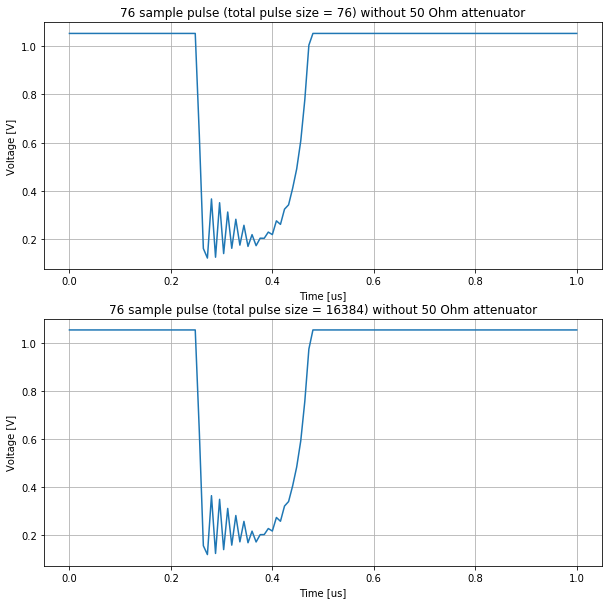

In [25]:
"Useful to check what setting impact pulse shape"

rp = scpi.scpi(IP)
fig = plt.figure(figsize=(10,10))
t = 8e-9*np.arange(0, 2**14)*1e6


s_sizes = [76, 2**14]
for i, size in enumerate(s_sizes):
    pulse, _ = sloping_pulse(size=size)
    
    setup_asg(output=1, waveform='arbitrary', data=pulse, frequency=2.5e4, amplitude=1, burst_mode=True)
    array = acq_signal(source=1, trigger_delay=2**14/2)
    ax = fig.add_subplot(2, 1, i+1)
    ax.plot(t[:_+50], array[:_+50])
    ax.set_ylabel('Voltage [V]')
    ax.set_xlabel('Time [us]')
    ax.grid()
    ax.set_title(f'{_} sample pulse (total pulse size = {size}) without 50 Ohm attenuator')

# Channel 1 is on HV!

Requirements:
1. 10-90 (of 2V) rise time of 100 ns   
2. Programmability of the on and off time of pulses in steps of 100 ns (or less)
3. Ability to send out pulses on first and second output that are synchronised
4. Overshoot of less than 15%

(-819.1500000000001, 1000)

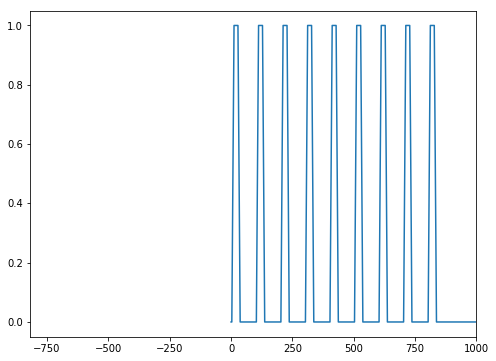

In [36]:
"Double input pulse"
DC = np.ones(2**14)

end = 1076
pulse1 = sloping_pulse(start=0, slope_length=80, pulse_width=120,)
pulse2 = sloping_pulse(slope_length=80, pulse_width=120, start=7000)
#pulse3 = sloping_pulse(start=250, slope_length=80, pulse_width=80,)

multi = np.copy(pulse1)
for i in range(8):
    multi += shift(pulse1, 100*(i+1))

plt.plot(multi)
plt.xlim(right=1000)

In [37]:
rp = scpi.scpi(IP)

maxf = 7629

rp.tx_txt('GEN:RST')

setup_asg(output=1, waveform='arbitrary', data=multi, frequency=maxf, amplitude=1, burst_mode=True, bursts=1)
#setup_asg(output=2, waveform='arbitrary', data=poelse_off, frequency=1e4, amplitude=0.1, burst_mode=True, bursts=1)

# setup_asg(output=1, waveform='square', amplitude=1)
# setup_asg(output=2, amplitude=1)

# rp.tx_txt('SOUR1:TRIG:IMM')


In [38]:
rp.tx_txt('SOUR:TRIG:IMM')

15

In [39]:
rp.tx_txt('OUTPUT1:STATE OFF')
rp.tx_txt('OUTPUT2:STATE OFF')

19

In [75]:
"Output one pulse and acquire on both channels"
"Remember to adjust scope gain setting accordingly!"

rp = scpi.scpi(IP)

rp.tx_txt('GEN:RST')

setup_asg(output=1, waveform='arbitrary', data=1-pulse1, frequency=1e4, amplitude=0.1, burst_mode=True, bursts=1)
setup_asg(output=2, waveform='arbitrary', data=1-pulse1, frequency=1e4, amplitude=0.1, burst_mode=True)


setup_scope(gain1='hv', gain2='lv', trigger_delay=int(2**14/2))
array1, array2 = acquire(channel='both')
#array2 = acquire(channel=2)

#setup_asg(output=1, waveform='arbitrary', data=DC, amplitude=1, burst_mode=False)
#array1 = acquire(channel=1)
#
# array11 = acq_signal(source=1, trigger_delay=0, gain='hv')
# array22 = acq_signal(source=2, trigger_delay=0, gain='lv')


both


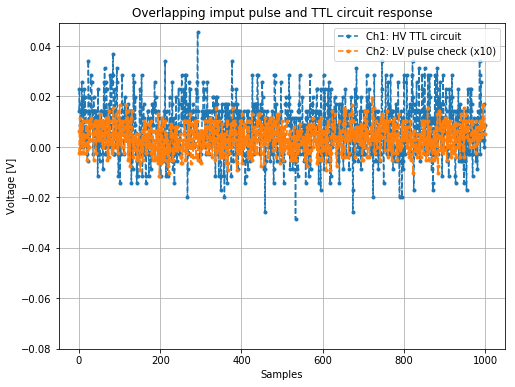

In [98]:
"Plot acquired signals"
t = np.linspace(0,2**14,2**14)
start = 0
end = 1000
timescale = 1

plt.plot(t[start:end]*timescale, array1[start:end], label='Ch1: HV TTL circuit', ls='--', marker='.')
plt.plot(t[start:end]*timescale, array2[start:end]*10, label='Ch2: LV pulse check (x10)', ls='--', marker='.')
plt.ylim( bottom=-0.08)
plt.legend()
plt.xlabel('Samples')
plt.ylabel('Voltage [V]')
plt.title('Overlapping imput pulse and TTL circuit response')
plt.grid()

# Playing around with Gary's FFT code

'Pulses seem very similar'

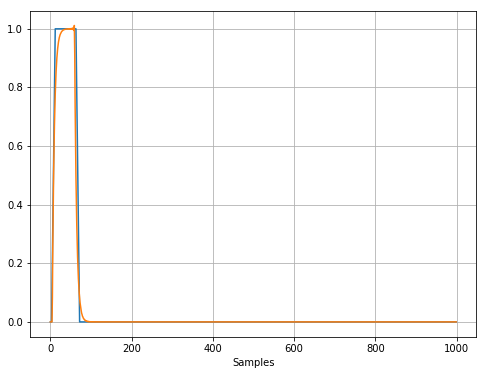

In [29]:
t = np.linspace(0,2**14,2**14)
v = (t > 5) * (t <= 60)

tau = 5
v_t = np.fft.fft(v)
f = np.fft.fftfreq(len(v), d=t[1])
h = 1/(1+1j*2*np.pi*f*tau)
vfilt_t = v_t*h
vfilt = np.real(np.fft.ifft(vfilt_t))
vfilt[:5] = 0
for i, value in enumerate(vfilt):
    vfilt[i] = np.format_float_scientific(value)

#plt.plot(8e-3*t[:100],v[:100], label="V_{in}")
plt.xlabel("Samples")
#plt.plot(8e-3*t[:100], vfilt[:100], label="V_{out}");
plt.grid()
plt.plot(slopey[:1000])
plt.plot(vfilt[:1000])

"Pulses seem very similar"

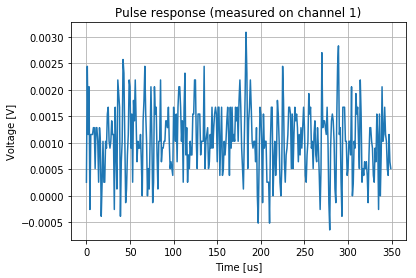

In [162]:
"Why does the FFT input pulse show only noise?"

rp = scpi.scpi(IP)

setup_asg(output=2, waveform='arbitrary', data=vfilt, frequency=1e4, amplitude=1, burst_mode=True)
array1 = acq_signal(source=2, trigger_delay=0, gain='lv')
#setup_asg(output=2, waveform='arbitrary', data=pulse2, frequency=2.5e4, amplitude=1, burst_mode=True)
#array2 = acq_signal(source=2, trigger_delay=2**14/2)

#plt.plot(t[8000:9500], array1[8000:9500])
plt.plot(array1[8150:8500])
plt.xlabel('Time [us]')
plt.ylabel('Voltage [V]')
plt.title('Pulse response (measured on channel 1)')
plt.grid()